# Exercise 8 - Python: Anomaly Detection and Recommender Systems

<img width="350px" src="https://upload.wikimedia.org/wikipedia/commons/0/07/Two-dimensional_Outliers_Example.png">

## *Part I*: Anomaly Detection

**[Explain section here]**

---

Beginning with package imports and data loading

In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio  # Used to load the Octave/MATLAB *.mat files
from scipy.stats import norm  # For estimating Gaussian probabilities
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

In [2]:
data = sio.loadmat('ex8/ex8data1.mat')

X = data['X']
Xval = data['Xval']
yval = data['yval']

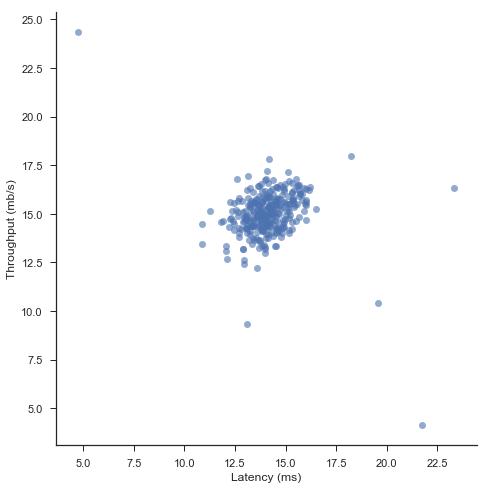

In [3]:
df = pd.DataFrame(X, columns=['Latency (ms)', 'Throughput (mb/s)'])

sns.lmplot(x='Latency (ms)', y='Throughput (mb/s)', data=df,
           fit_reg=False, size=7, scatter_kws={'alpha':0.6});

### Gaussian Distribution

Before performing anomaly detecting, we need to fit a model to the data's distribution.

Estimate the Gaussian distribution for each of the features $x_i$.  For each feature $i=1 \dots n$, find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, \dots, x_i^{(m)}\}$ (the $i$-th dimension of each example)

The Gaussian distribution is given by
$$p(x; \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} e ^ {-\frac{(x - \mu)^2}{2 \sigma^2}}
\\
\mu: \text{Mean}
\\
\sigma^2: \text{Controls the variance}$$

### Estimating Gaussian parameters

In order to estimate the parameters $(\mu_i, \sigma_i^2)$, of the $i$-th feature, we will use the following equations for the mean and variance:

$$\text{Mean: } \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}
\\
\text{Variance: } \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [4]:
def estimate_gaussian(X):
    """
    Takes the matrix X as an input and outputs:
    
    mu: n-dimension vector that holds the mean of all the n features
    sigma2: n-dimension vector that holds the variance of all features
    """
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    
    return mu, sigma2


mu, sigma2 = estimate_gaussian(X)

print('Mean:\n', mu,
      '\nVariance:\n', sigma2)

# Utilizing scipy to gather the PDF of the distribution
distribution = norm(mu[0], sigma2[0])

Mean:
 [ 14.11222578  14.99771051] 
Variance:
 [ 1.83263141  1.70974533]


Next, we'll plot the contour plot using our obtained mean and variance values

I borrowed some code from [kaleko's notebook](https://github.com/kaleko/CourseraML/blob/master/ex8/ex8.ipynb) in order to generate the contour plot (if you're reading this, thank you!)

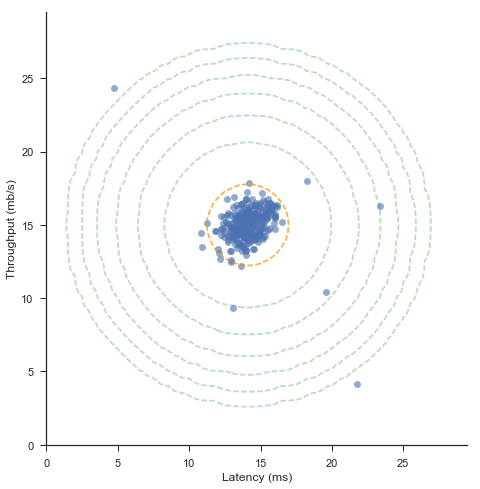

In [5]:
# Plotting the original data
sns.lmplot(
    x='Latency (ms)',
    y='Throughput (mb/s)',
    data=df,
    fit_reg=False,
    size=7,
    scatter_kws={'alpha': 0.6})


def gaus(myX, mymu, mysig2):
    """
    Function to compute the gaussian return values for a feature
    matrix, myX, given the already computed mu vector and sigma matrix.
    If sigma is a vector, it is turned into a diagonal matrix
    """
    m = myX.shape[0]
    n = myX.shape[1]
    if np.ndim(mysig2) == 1:
        mysig2 = np.diag(mysig2)

    norm = 1. / (np.power((2 * np.pi), n / 2) * np.sqrt(np.linalg.det(mysig2)))
    myinv = np.linalg.inv(mysig2)
    myexp = np.zeros((m, 1))
    for irow in range(m):
        xrow = myX[irow]
        myexp[irow] = np.exp(-0.5 * (
            (xrow - mymu).T).dot(myinv).dot(xrow - mymu))
    return norm * myexp


def plot_contour(mu, sigma, delta=0.5):
    """
    Plots the Gaussian distribution contour and cutoff point
    """
    # Creating the meshgrid to (insert why here)
    dim = np.arange(0, 30, delta)
    dx, dy = np.meshgrid(dim, dim)
    coord_list = [x.ravel() for x in (dx, dy)]
    points = np.vstack(coord_list).T
    
    # Converting into a Gaussian distribution
    Z = gaus(points, mu, sigma2)
    Z = Z.reshape((dx.shape[0], dx.shape[0]))
    cont_levels = [10**exp for exp in range(-20, 0, 3)]

    # Plotting the Gaussian contour plots
    # Using orange for the boundary for outliers, and green for the rest
    plt.contour(dx, dy, Z, levels=[cont_levels[-1]], linestyles='dashed',
                colors='darkorange', alpha=0.7)
    plt.contour(dx, dy, Z, levels=cont_levels[:-1], linestyles='dashed',
                colors='forestgreen', alpha=0.3)


plot_contour(mu, sigma2)

### Selecting the threshold $\epsilon$

With the Gaussian parameters, we can see which points are more or less likely to be outliers according to their probabilities in the distribution.  We can determine the threshold for outliers with the cross validation set.

We'll do this by optimizing the $F_1$ score on the cross validation set.  As a reminder, the $F_1$ score is a mix of precision and recall:

$$F_1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$

and precision and recall are calculated as follows:

$$precision = \frac{True Positive}{True Positive + False Positive}
\\
recall = \frac{True Positive}{True Positive + False Negative}$$

In [6]:
def select_threshold(Xval, yval, distribution):
    """
    Selects the threshold for determining outliers according to which minimizes
    our F1 score on the validation set
    
    Returns the threshold and the F1 score
    """
    # Creating variables to be replaced
    optimalEpsilon = 0
    optimalF1 = 0

    # Generating the probability of the point according to the distribution
    probability = distribution.pdf(Xval)

    # Setting the size of steps for trying different values of epsilon
    stepSize = probability.max() / 1000

    # Looping through values of epsilon to find the optimal value
    for epsilon in np.arange(probability.min() + stepSize,
                             probability.max(), stepSize):
        prediction = probability < epsilon

        # Calculating true/false positives/negatives
        truePositive = np.sum(np.logical_and(prediction == 1, yval == 1))
        falsePositive = np.sum(np.logical_and(prediction == 1, yval == 0))
        falseNegative = np.sum(np.logical_and(prediction == 0, yval == 1))

        # Calculating the F1 score
        precision = truePositive / (truePositive + falsePositive)
        recall = truePositive / (truePositive + falseNegative)
        f1 = (2 * precision * recall) / (precision + recall)

        # Checks if current f1 is better, and replaced optimalF1 if so
        if f1 > optimalF1:
            optimalEpsilon = epsilon
            optimalF1 = f1

    return optimalEpsilon, optimalF1


results = select_threshold(Xval, yval, distribution)

print('Epsilon (cutoff):', results[0],
      '\nF1 Score:', results[1])

Epsilon (cutoff): 0.0376600629603 
F1 Score: 0.689655172414


Now that we have our cutoff, let's assign it to our data set and plot the results

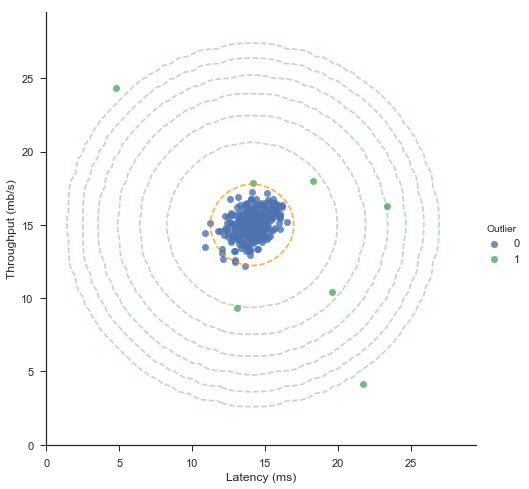

In [7]:
# Calculating the probability density for the original data points
df['LatencyProb'] = norm(mu[0], sigma2[0]).pdf(df['Latency (ms)'])
df['ThroughputProb'] = norm(mu[0], sigma2[0]).pdf(df['Throughput (mb/s)'])

# Assigning outliers based on our obtained epsilon
df['Outlier'] = np.where(((df['LatencyProb'] < results[0]) |
                          (df['ThroughputProb'] < results[0])), 1, 0)

# Plotting the data with outliers
sns.lmplot(
    x='Latency (ms)',
    y='Throughput (mb/s)',
    hue='Outlier',
    data=df,
    fit_reg=False,
    size=7)

plot_contour(mu, sigma2)

While this color pallet isn't that great at displaying contrasts, we can see that most points outside of our initial level of the contour plot are considered outliers

### High dimensional dataset

This last section of part I does the same things on a dataset that is much more similar to a realistic scenario.  We won't be able to plot this without using a dimensionality reduction algorithm like [$t$-SNE](https://distill.pub/2016/misread-tsne/), but we can at least view our acquired $\epsilon$ and F1 score

In [8]:
# Importing the data
data = sio.loadmat('ex8/ex8data2.mat')
X = data['X']
Xval = data['Xval']
yval = data['yval']

# Calculating the parameters of the variables
mu, sigma2 = estimate_gaussian(X)
print('Mean:\n', mu,
      '\nVariance:\n', sigma2)

# Utilizing scipy to gather the PDF of the distribution
distribution = norm(mu[0], sigma2[0])

# Calculating the cutoff and F1 score
results = select_threshold(Xval, yval, distribution)
print('\nEpsilon (cutoff):', results[0],
      '\nF1 Score:', results[1])

Mean:
 [  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252] 
Variance:
 [ 60.97489373  53.20572186  58.51546272  84.20403725  65.26859177
  89.57487757  55.63349911  87.16233783  29.62926829  70.7852052
  50.50356719]

Epsilon (cutoff): 0.00640501131254 
F1 Score: 0.231404958678


---

## *Part II*: Recommender Systems

**[Explain section here]**

### Moving ratings dataset

**[Insert joke about Movielens]**

### Collaborative Filtering

#### Collaborative Filtering Cost Function

#### Collaborative Filtering Gradient

#### Regularized Cost Function

#### Regularized Gradient

### Learning Movie Recommendations